<a href="https://colab.research.google.com/github/JosephGesnouin/StageLiesse2021/blob/main/3_Plus_proches_voisins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage LIESSE – TP 3 – Plus proches voisins 

Le but de ce notebook est de présenter lees algorithmes de plus proches voisins.

## Chargement des librairies

In [ ]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [ ]:
import pandas as pd

In [ ]:
import sklearn

## 1. Plus proches voisins pour la régression 

Nous reprenons le Problème 1 défini dans le notebook `0-Donnees.ipynb`. 

### Chargement des données

In [ ]:
import pandas as pd
!wget https://raw.githubusercontent.com/chagaz/ml-notebooks/master/liesse/data/penguins.csv

penguins = pd.read_csv("/content/penguins.csv")

--2021-04-29 07:14:02--  https://raw.githubusercontent.com/chagaz/ml-notebooks/master/liesse/data/penguins.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16286 (16K) [text/plain]
Saving to: ‘penguins.csv.1’

penguins.csv.1      100%[===================>]  15.90K  --.-KB/s    in 0.001s  

2021-04-29 07:14:02 (27.5 MB/s) - ‘penguins.csv.1’ saved [16286/16286]



In [ ]:
X = penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]].to_numpy()
y_regress = penguins["body_mass_g"]

### Séparation des données en jeu d'entraînement et jeu de test

In [ ]:
from sklearn import model_selection

In [ ]:
(X_train, X_test, y_train, y_test) = model_selection.train_test_split(X, y_regress, test_size=0.3, random_state=25)

### Formalisme 

Nous disposons toujours d'un jeu d'entraînement de $n$ observations en $p$ dimensions, représentés par une matrice $X \in \mathbb{R}^{nxp}$ (ici, $p=3$), et d'un vecteur d'étiquettes $\boldsymbol{y} \in \mathbb{R}^{n}$. 

L'étiquette d'une observation $\boldsymbol{x}$ est prédite comme la moyenne des étiquettes des $k$ éléments du jeu d'entraînement les plus proches de $\boldsymbol{x}$ : 
$$f(\boldsymbol{x}) = \frac1k \sum_{i : \boldsymbol{x}_i \in \mathcal{N}_k(\boldsymbol{x})} y_i,$$
où $\mathcal{N}_k(\boldsymbol{x})$ désigne les $k$ éléments de $\{\boldsymbol{x}_1, \boldsymbol{x}_2, \dots, \boldsymbol{x}_n\}$ les plus proches de $\boldsymbol{x}$ (au sens de la distance euclidienne).

Une particularité de cette algorithme est qu'il n'a pas de phase d'apprentissage du modèle ; on parle parfois d'apprentissage paresseux, ou _lazy learning_.

### kNN avec scikit-learn

Les algorithmes de plus proches voisins sont implémentés dans [le module `neighbors`](https://scikit-learn.org/stable/modules/classes.html?highlight=neighbors#module-sklearn.neighbors) de `scikit-learn`. Pour la régression, nous utilisons [la classe `KNeighborsRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). 

Nous allons fixer ici le nombre de plus proches voisins $k$ à 7.

In [ ]:
from sklearn import neighbors

Nous suivons toujours les étapes habituelles :

1. Instancions un objet de la classe `KNeighborsRegressor`.

In [ ]:
knnreg = neighbors.KNeighborsRegressor(n_neighbors=7)

2. Entraînons cet objet sur les données d'entraînement avec la méthode `fit` :

Ici, l'entraînement consiste uniquement à définir l'ensemble des observations étiquetées parmi lesquelles chercher les voisins d'une observation.

In [ ]:
knnreg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')

3. Enfin, prédisons les étiquettes des données du jeu de test en utilisant la méthode `predict` :

In [ ]:
y_test_pred = knnreg.predict(X_test)

### Performance du modèle

On peut maintenant s'intéresser à la qualité du modèle. Commençons par visualiser la corrélation entre les valeurs réelles et les valeurs prédites :

Text(0, 0.5, 'Poids prédit (g)')

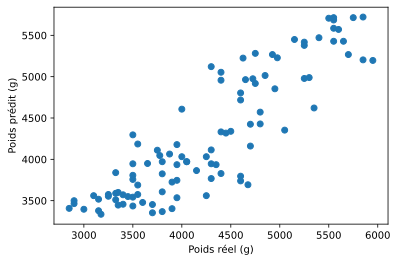

In [ ]:
plt.scatter(y_test, y_test_pred)

plt.xlabel("Poids réel (g)")
plt.ylabel("Poids prédit (g)")

In [ ]:
from sklearn import metrics

In [ ]:
print("La RMSE de notre modèle est %.2f g" % (metrics.mean_squared_error(y_test, y_test_pred, squared=False)))

La RMSE de notre modèle est 388.20 g


In [ ]:
print("Le coefficient de détermination de notre modèle est R2 = %.2f" % (metrics.r2_score(y_test, y_test_pred)))

Le coefficient de détermination de notre modèle est R2 = 0.77


## 2. Plus proches voisins pour la classification

Reprenons une fois de plus le Problème 2 défini dans le notebook `0-Donnees.ipynb`. 

### Chargement des données

In [ ]:
y_classif = pd.Categorical(penguins["sex"]).astype('category').codes

### Séparation des données en jeu d'entraînement et jeu de test

In [ ]:
(X_train, X_test, y_train, y_test) = model_selection.train_test_split(X, y_classif, test_size=0.3, random_state=25, 
                                                                      stratify=y_classif)

### Formalisme 

Plutôt que d'utiliser la _moyenne_ des étiquettes des $k$ plus proches voisins, dans le cas de la classification, on utilise la _classe majoritaire_ parmi les étiquettes des $k$ plus proches voisins.

En supposant un jeu d'entraînement de $n$ observations en $p$ dimensions, représentés par une matrice $X \in \mathbb{R}^{nxp}$, et un vecteur d'étiquettes $\boldsymbol{y} \in \{0, 1\}^{n}$, l'étiquette d'une observation $\boldsymbol{x}$ est prédite comme : 
$$f(\boldsymbol{x}) = \arg\max_{c \in \{0, 1\}} \sum_{i : \boldsymbol{x}_i \in \mathcal{N}_k(\boldsymbol{x})} \delta(y_i, c),$$
où $\delta(y_i, c)$ est l'indicatrice qui vaut $1$ si $y_i = c$ et $0$ sinon.

### kNN avec scikit-learn

Pour la classification, nous utilisons [la classe `KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). 

1. Instancions un objet de la classe `KNeighborsRegressor`.

In [ ]:
knnclass = neighbors.KNeighborsClassifier(n_neighbors=7)

2. Entraînons cet objet sur les données d'entraînement avec la méthode `fit` :

In [ ]:
knnclass.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

3. Enfin, prédisons les étiquettes des données du jeu de test en utilisant la méthode `predict` :

In [ ]:
y_test_pred = knnclass.predict(X_test)

### Performance

Regardons la __matrice de confusion__ des prédictions :

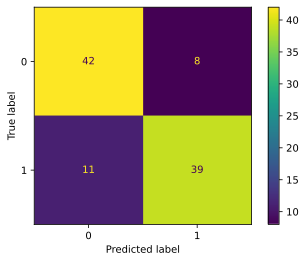

In [ ]:
metrics.plot_confusion_matrix(knnclass, X_test, y_test)

In [ ]:
print("%d manchots mâles ont été incorrectement prédits femelle." % metrics.confusion_matrix(y_test, y_test_pred)[1, 0])
print("%d manchots femelles ont été incorrectement prédits mâles." % metrics.confusion_matrix(y_test, y_test_pred)[0, 1])

11 manchots mâles ont été incorrectement prédits femelle.
8 manchots femelles ont été incorrectement prédits mâles.


In [ ]:
print("%.f%% des prédictions du modèle sur le jeu de test sont correctes." % (100*metrics.accuracy_score(y_test, y_test_pred)))

81% des prédictions du modèle sur le jeu de test sont correctes.


## Pour aller plus loin

### Annexe 1 : Sélection du nombre de plus proches voisins par validation croisée

Dans ce notebook, nous avons fixé le nombre de plus proches voisins $k$ (`n_neighbors` dans les paramètres de `KNeighborsClassifier` ou `KNeighborsRegressor`) à $k=7$. 

Nous allons maintenant voir comment __sélectionner__ la meilleure valeur de $k$ dans une liste. On parle ici de __sélection de modèle__.

$k$ est un __hyperparamètre__ du modèle ; l'algorithme des k plus proches voisins nous dit comment procéder à $k$ fixé et le choix de $k$ ne fait pas partie de la procédure. De la même façon, le nombre de couches intermédiaires dans un réseau de neurones est un hyperparamètre. À l'inverse, les coefficients d'une régression linéaire sont des __paramètres__ du modèle, car c'est eux que la procédure d'apprentissage/entraînement/_fit_ cherche à déterminer.

On peut imaginer approcher cette question en évaluant, sur le jeu de test, la performance de plusieurs $k$NNs, utilisant différentes valeurs de $k$. Il s'agirait alors de choisir la valeur de $k$ donnant la meilleure performance. Cependant, la performance sur le jeu de test du $k$NN sélectionné ne reflète pas bien la performance en généralisation modèle : les données que nous utilisons pour l'évaluation ne sont plus utilisées qu'à ce seul but, puisqu'elles ont aussi été utilisées pour la sélection du modèle.

Il faut donc utiliser uniquement le jeu d'entraînement pour la sélection de modèle.

On peut de nouveau séparer ce jeu de données en deux jeux, un jeu d'entraînement et un jeu de validation. On évaluera alors les performances de $k$NNs entraînés sur ce nouveau jeu d'entraînement en comparant leurs performances sur le jeu de validation.

Cependant, si nous utilisons de nouveau les proportions 70/30 pour créer ce nouveau jeu d'entraînement, on utilise alors 49% des données seulement pour l'entraînement ! C'est peu, surtout si le jeu de données est assez petit ; en effet, plus on a de données, mieux on apprend. On préfère ainsi en pratique utiliser une __validation croisée__ sur le jeu d'entraînement. Il s'agit de découper le jeu d'entraînement en C blocs (appelés _folds_ en anglais ; typiquement C=5 ou C=10), et de faire une série de C expériences dans lesquelles un des blocs est utilisé comme jeu de validation et les (C-1) autres blocs forment le jeu d'entraînement. Ainsi, chaque bloc de données est utilisé une fois pour la validation et (C-1) fois pour l'entraînement. On obtient ainsi C mesures de performance (pour chaque valeur de $k$), que l'on moyenne, et on choisit la valeur de $k$ donnant la meilleure performance moyenne.

#### GridSearchCV

Cette procédure est automatisée dans [la classe `GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) du module `model_selection` de `scikit-learn`

On procède alors de la façon suivante :

1. Fixons une liste de valeurs à évaluer pour l'hyperparamètre $k$

Nous choisissons ici uniquement des valeurs impaires, pour faciliter la détermination de la classe majoritaire dans le cas d'une classification binaire (avec un nombre pair de voisin, on peut ne pas avoir de classe majoritaire).

In [ ]:
n_neighbors_values = [5, 7, 9, 13, 15, 17, 19, 21]

2. Initialisons un objet de la classe `GridSearchCV`, auquel nous passons comme paramètres :
* la classe de modèle qui nous intéresse, ici `KNeighborsClassifier` pour le problème de classification ;
* un dictionnaire indiquant, pour chacun des paramètres de ce modèle à évaluer (ici nous en avons un seul, `n_neighbors`), la liste de valeurs à tester (`n_neighbors_values`) ;
* le nombre de _folds_ (ici 5) ;
* la fonction de score à utiliser pour déterminer la performance d'un modèle ; ici nous allons utiliser l'_accuracy_. Pour plus de possibilités, voir [la documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules).

In [ ]:
knnclass_cv = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(),
                                          {'n_neighbors': n_neighbors_values}, cv=5, scoring='accuracy')

3. Faisons tourner la validation croisée sur le jeu d'entraînement

In [ ]:
knnclass_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [5, 7, 9, 13, 15, 17, 19, 21]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

#### Nombre optimal de voisins 

Nous avons maintenant accès au nombre optimal de voisins ainsi qu'à l'_accuracy_ correspondante, qui sont des attributs de `knnclass_cv` : 

In [ ]:
print("La valeur optimale de k est %d, pour une accuracy cross-validée de %.f%%." % (knnclass_cv.best_params_['n_neighbors'], (100*knnclass_cv.best_score_)))

La valeur optimale de k est 5, pour une accuracy cross-validée de 83%.


#### Performance du modèle optimal

Nous avons aussi accès au modèle optimal, c'est-à-dire le modèle entraîné sur l'intégralité du jeu d'entraînement, avec la valeur optimale de $k$, dans `knnclass_cv.best_estimator_`. Nous pouvons donc évaluer sa performance sur le jeu de test.

In [ ]:
y_test_pred = knnclass_cv.best_estimator_.predict(X_test)

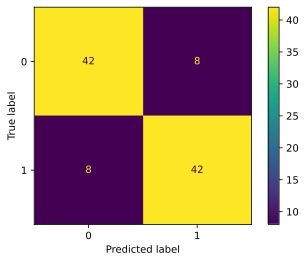

In [ ]:
metrics.plot_confusion_matrix(knnclass_cv.best_estimator_, X_test, y_test)

In [ ]:
print("%d manchots mâles ont été incorrectement prédits femelle." % metrics.confusion_matrix(y_test, y_test_pred)[1, 0])
print("%d manchots femelles ont été incorrectement prédits mâles." % metrics.confusion_matrix(y_test, y_test_pred)[0, 1])

8 manchots mâles ont été incorrectement prédits femelle.
8 manchots femelles ont été incorrectement prédits mâles.


In [ ]:
print("%.f%% des prédictions du modèle sur le jeu de test sont correctes." % (100*metrics.accuracy_score(y_test, y_test_pred)))

84% des prédictions du modèle sur le jeu de test sont correctes.


### Annexe 2 : Plus proche voisin (au singulier) sans scikit-learn

Nous allons maintenant voir comment implémenter l'algorithme du plus proche voisin ($k$=1) sans utiliser `scikit-learn`.

In [ ]:
def my_nearest_neighbor(x, Xtr, ytr):
    """
    Retourne l'étiquette du plus proche voisin dans Xtr de x.
    
    Parameters
    ----------
    x: np.array of shape (p, )
        L'observation à étiquetter
        
    Xtr: np.array of shape (n, p)
        La matrice de données d'entrainement
        
    ytr: np.array of shape (n, )
        Les étiquettes des données d'entrainement.    
    """
    
    # Calculer les carrés distances euclidiennes entre x et chaque ligne de Xtr
    squared_distances = [np.sum((x - Xtr[idx, :])**2) for idx in range(Xtr.shape[0])]
    
    # Trouver l'indice de la plus petite de ces valeurs 
    nn_idx = np.argmin(squared_distances)
    
    # Retourner l'étiquette correspondante
    return ytr[nn_idx]

Nous pouvons maintenant utiliser cette fonction sur toutes les observations de `X_test` pour obtenir les prédictions :

In [ ]:
my_y_test_pred = [my_nearest_neighbor(X_test[idx, :], X_train, y_train) for idx in range(X_test.shape[0])]

Nous pouvons comparer ces prédictions à celles de `scikit-learn` :

In [ ]:
onnclass = neighbors.KNeighborsClassifier(n_neighbors=1)
onnclass.fit(X_train, y_train)
y_test_pred = onnclass.predict(X_test)

In [ ]:
my_y_test_pred - y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

### Annexe 3 : Plus proches voisins (au pluriel) sans scikit-learn

#### Pour la classification

In [ ]:
(X_train, X_test, y_train, y_test) = model_selection.train_test_split(X, y_classif, test_size=0.3, random_state=25)

In [ ]:
def my_k_nearest_neighbors_classif(x, Xtr, ytr, k):
    """
    Retourne l'étiquette de la plus fréquente parmi les k plus proches voisins dans Xtr de x.
    
    Parameters
    ----------
    x: np.array of shape (p, )
        L'observation à étiquetter
        
    Xtr: np.array of shape (n, p)
        La matrice de données d'entrainement
        
    ytr: np.array of shape (n, )
        Les étiquettes des données d'entrainement.  
        
    k: int
        Nombre de plus proches voisins
    """
    
    # Calculer les carrés distances euclidiennes entre x et chaque ligne de Xtr
    squared_distances = [np.sum((x - Xtr[idx, :])**2) for idx in range(Xtr.shape[0])]
    
    # Trouver les indices des k plus petites valeurs dans cette liste,
    # en récupérant les k premiers indices de la liste triée
    closest_indices = np.argsort(squared_distances)[:k]
    
    # Retourner l'étiquette la plus fréquente dans cette liste
    # qui est 1 si la moyenne des étiquettes est supérieure à 0.5 et 0 sinon
    return (1 if (np.mean(ytr[closest_indices])) > 0.5 else 0)

Nous pouvons maintenant utiliser cette fonction sur toutes les observations de `X_test` pour obtenir les prédictions :

In [ ]:
my_y_test_pred = [my_k_nearest_neighbors_classif(X_test[idx, :], X_train, y_train, 7) for idx in range(X_test.shape[0])]

Nous pouvons comparer ces prédictions à celles de `scikit-learn` :

In [ ]:
knnclass = neighbors.KNeighborsClassifier(n_neighbors=7)
knnclass.fit(X_train, y_train)
y_test_pred = knnclass.predict(X_test)

In [ ]:
y_test_pred = knnclass.predict(X_test)

In [ ]:
my_y_test_pred - y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Pour la régression

In [ ]:
(X_train, X_test, y_train, y_test) = model_selection.train_test_split(X, y_regress, test_size=0.3, random_state=25)

In [ ]:
def my_k_nearest_neighbors_regress(x, Xtr, ytr, k):
    """
    Retourne la moyenne des étiquettes des k plus proches voisins dans Xtr de x.
    
    Parameters
    ----------
    x: np.array of shape (p, )
        L'observation à étiquetter
        
    Xtr: np.array of shape (n, p)
        La matrice de données d'entrainement
        
    ytr: np.array of shape (n, )
        Les étiquettes des données d'entrainement.  
        
    k: int
        Nombre de plus proches voisins
    """
    
    # Calculer les carrés distances euclidiennes entre x et chaque ligne de Xtr
    squared_distances = [np.sum((x - Xtr[idx, :])**2) for idx in range(Xtr.shape[0])]
    
    # Trouver les indices des k plus petites valeurs dans cette liste,
    # en récupérant les k premiers indices de la liste triée
    closest_indices = np.argsort(squared_distances)[:k]
    
    #print(list(closest_indices))
    
    # Retourner la moyenne des étiquettes dans cette liste
    return (np.mean(ytr[tuple([closest_indices])]))

Nous pouvons maintenant utiliser cette fonction sur toutes les observations de `X_test` pour obtenir les prédictions :

Attention, `y_train` est une série pandas ; pour obtenir l'array numpy correspondant, nous utilisons `y_train.values`.

In [ ]:
my_y_test_pred = [my_k_nearest_neighbors_regress(X_test[idx, :], X_train, y_train.values, 7) for idx in range(X_test.shape[0])]

Nous pouvons comparer ces prédictions à celles de `scikit-learn` :

In [ ]:
knnreg = neighbors.KNeighborsRegressor(n_neighbors=7)
knnreg.fit(X_train, y_train)
y_test_pred = knnreg.predict(X_test)

In [ ]:
y_test_pred = knnreg.predict(X_test)

In [ ]:
my_y_test_pred - y_test_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])